## Monte Carlo Simulation

The COVID scare was a wake-up call, highlighting the vulnerability of our hyper-connected modern world to the threat of pandemics. Now that the COVID urgency has passed, governments across the globe are rushing to update their emergency action plans and disaster scripts.

As part of this effort, you’ve been hired by a medical team that has been tasked with developing fast procedures to detect a blood-borne virus. 

Since these tests need to be administered to large groups in the population, and testing resources are limited, the medics have come up with the following procedure: 

1. They started from the assumption that they need to test $N$ blood samples (of as many different individuals) and that $N$ is large (e.g., $N = 10^6$). 
2. Furthermore, the probability that an individual is infected is $p$, where $p$ is relatively small, e.g., $p < 0.1$.

Based on these assumptions they propose the following procedure to minimise the number of tests they have to run: Rather than testing each sample individually, take a batch of $k$ samples and mix them. Then this mixed sample is tested for the presence of the viral antigen:

- If the mixed sample tests **negative** (i.e., no viral antigen is detected), then all the individual samples were clear, and you therefore have the result for all $k$ individual samples that went into the batch.
- If the mixed sample tests **positive** (i.e., the viral antigen is present indicating infection), one needs to retest all individual samples that went into the batch, in order to find out which individual(s) are actually infected.

**Questions**
1. Use Monte Carlo simulation to estimate the optimal batch size $k$ (i.e., the one that minimises the expected number of tests) for a given value of $p$ where $p$ can take values between $10^{-1}$ and $10^{-4}$.
2. In order to convince your superiors that this a good investment, quantify the **expected reduction in workload** (compared to testing all samples individually).

### Class and Functions

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [221]:
class Monte_Carlo:
    def __init__(self, 
                 probability, 
                 batch_size, 
                 sample_size = 1000000):
        self.p = probability
        self.k = batch_size
        self.N = sample_size
    
    # Calculate X
    def generate_sample(self):
        # Generate and return a random sample
        return np.random.choice(
            a=[1, 0], # positive / negative
            size=self.N, 
            p=[self.p, 1-self.p])
    
    # Calculate Expected Number of Tests
    def calculate_n_tests(self):
        # Getting the random sample
        X = self.generate_sample()

        # Counter for Number of Tests
        n_tests = 0

        # Splitting the sample into batches and counting tests
        for i in range(0, len(X), self.k):
            batch = X[i:i + self.k]
            # Testing the batch
            n_tests += 1
            # If any positive, test everyone individually
            if any(individual == 1 for individual in batch):  # If any positive, test each individually
                n_tests += len(batch)
    
        return n_tests
    
    # Calculating the Expected Probability and SD of Finding a Positive in a Given Batch
    def probability_positive_in_batch(self):
        # Getting the random sample
        X = self.generate_sample()
        
        # List for Storing the Results
        all_results = []

        # Dividing the samples
        samples = [X[i:i + self.k] for i in range(0, len(X), self.k)]

        # Testing all Samples
        all_results = [any(individual == 1 for individual in batch) for batch in samples]

        # Getting the Expected Probability and SD
        MC_mean = np.mean(all_results)
        MC_mean_sd = np.std(all_results) / np.sqrt(self.N)

        return {"e_mean": MC_mean, "e_mean_sd": MC_mean_sd}


In [222]:
def simulate_monte_carlo(probabilities, k_values, sample_size=100000):
    # Initialize an empty DataFrame
    results_df = pd.DataFrame(index=k_values, columns=probabilities)

    # Iterating over the different Batch Sizes
    for k in k_values:
        # Iterating over the different Probabilities
        for p in probabilities:
            monte_carlo = Monte_Carlo(probability=p, batch_size=k, sample_size=sample_size)
            n_tests = monte_carlo.calculate_n_tests()
            results_df.loc[k, p] = n_tests

    return results_df

In [223]:
def find_optimal_batch_size(df):
    optimal_batches = {}

    for p in df.columns:
        optimal_k = df[p].idxmin()
        optimal_batches[p] = optimal_k

    return optimal_batches

In [224]:
def plot_MC_sim(df):
    # Define color mapping
    distinct_colors = plt.cm.tab20(np.linspace(0, 1, 20))  # 20 distinct colors
    # More gradual colors for k > 20
    gradual_colors = plt.cm.viridis(np.linspace(0, 1, len(df.index) - 20))
    
    # Combine color lists
    colors = np.vstack((distinct_colors, gradual_colors))

    plt.figure(figsize=(14, 8))
    
    # Plot each batch size with its color
    for i, k in enumerate(df.index):
        if k <= 20 or k % 10 == 0:
            label = f'Batch Size: {k}'
        else:
            label = None  # Only label specific lines
        plt.plot(df.columns, df.loc[k], color=colors[i], label=label)

    # Add a dashed horizontal line at y = 1000000
    plt.axhline(y=1000000, color='red', linestyle='--', linewidth=2)

    # Add labels and title
    plt.xlabel('Probability')
    plt.ylabel('Number of Tests')
    plt.title('Number of Tests by Batch Size and Probability')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()


In [239]:
import plotly.graph_objs as go
from plotly.offline import plot
import numpy as np
import matplotlib.pyplot as plt

def plot_interactive_monte_carlo(results_df, title='Number of Tests by Batch Size and Probability', horizontal_line_y=1000000):
    # Assuming you are working in a Jupyter notebook environment
    # init_notebook_mode(connected=True)  # Uncomment this if in Jupyter

    # Create an empty list to hold all the plot traces
    traces = []

    # Define color mapping
    distinct_colors = plt.cm.tab20(np.linspace(0, 1, 5))  # distinct colors
    gradual_colors = plt.cm.viridis(np.linspace(0, 1, len(results_df.index) - 5))
    colors = np.vstack((distinct_colors, gradual_colors))

    # Convert the colors to hex format for Plotly
    colors_hex = ['rgb({}, {}, {})'.format(int(c[0]*255), int(c[1]*255), int(c[2]*255)) for c in colors]

    # Add a trace for each batch size
    for i, k in enumerate(results_df.index):
        traces.append(go.Scatter(
            x=results_df.columns,
            y=results_df.loc[k],
            mode='lines',
            name=f'Batch Size: {k}',
            line=dict(color=colors_hex[i])
        ))

    # Define the layout of the plot
    layout = go.Layout(
        title=title,
        xaxis=dict(title='Probability'),
        yaxis=dict(title='Number of Tests', range=[0, results_df.values.max() + results_df.values.max() * 0.1]),
        hovermode='closest'
    )

    # Define the figure
    fig = go.Figure(data=traces, layout=layout)

    # Add a horizontal line at y = horizontal_line_y
    fig.add_shape(
        type='line',
        x0=results_df.columns.min(),
        y0=horizontal_line_y,
        x1=results_df.columns.max(),
        y1=horizontal_line_y,
        line=dict(dash='dash', color='grey', width=1)
    )

    # Show the figure
    # fig.show()  # Use iplot(fig) if within Jupyter Notebook, fig.show() if not
    return(fig)

### Sim 1: P: 0.0001 - 0.1000 (0.005), k: 2 - 100

In [7]:
# Blood Samples
N = 1000000

# Probabilities: from 0.1 to 0.0001
start = 0.0001
end =   0.1000
step =  0.0050
probabilities = np.arange(start, end + step, step)

# Probabilities: from 0.1 to 0.0001
batch_sizes = range(2,100)

# Simulation
sim_1 = simulate_monte_carlo(probabilities, batch_sizes, sample_size=N)

In [42]:
# Saving the dataframe
sim_1.to_csv('../MAS - Individual Assignment/sim_1.csv', index=True)

In [15]:
# Optimal Batch Size
sim_1_optimals = find_optimal_batch_size(sim_1)
print(sim_1_optimals)

{0.0001: 76, 0.0051: 15, 0.0101: 10, 0.015099999999999999: 8, 0.0201: 8, 0.0251: 7, 0.0301: 6, 0.035100000000000006: 6, 0.040100000000000004: 6, 0.0451: 5, 0.050100000000000006: 5, 0.0551: 5, 0.0601: 5, 0.0651: 4, 0.07010000000000001: 4, 0.0751: 4, 0.0801: 4, 0.08510000000000001: 4, 0.0901: 4, 0.0951: 4, 0.10010000000000001: 4}


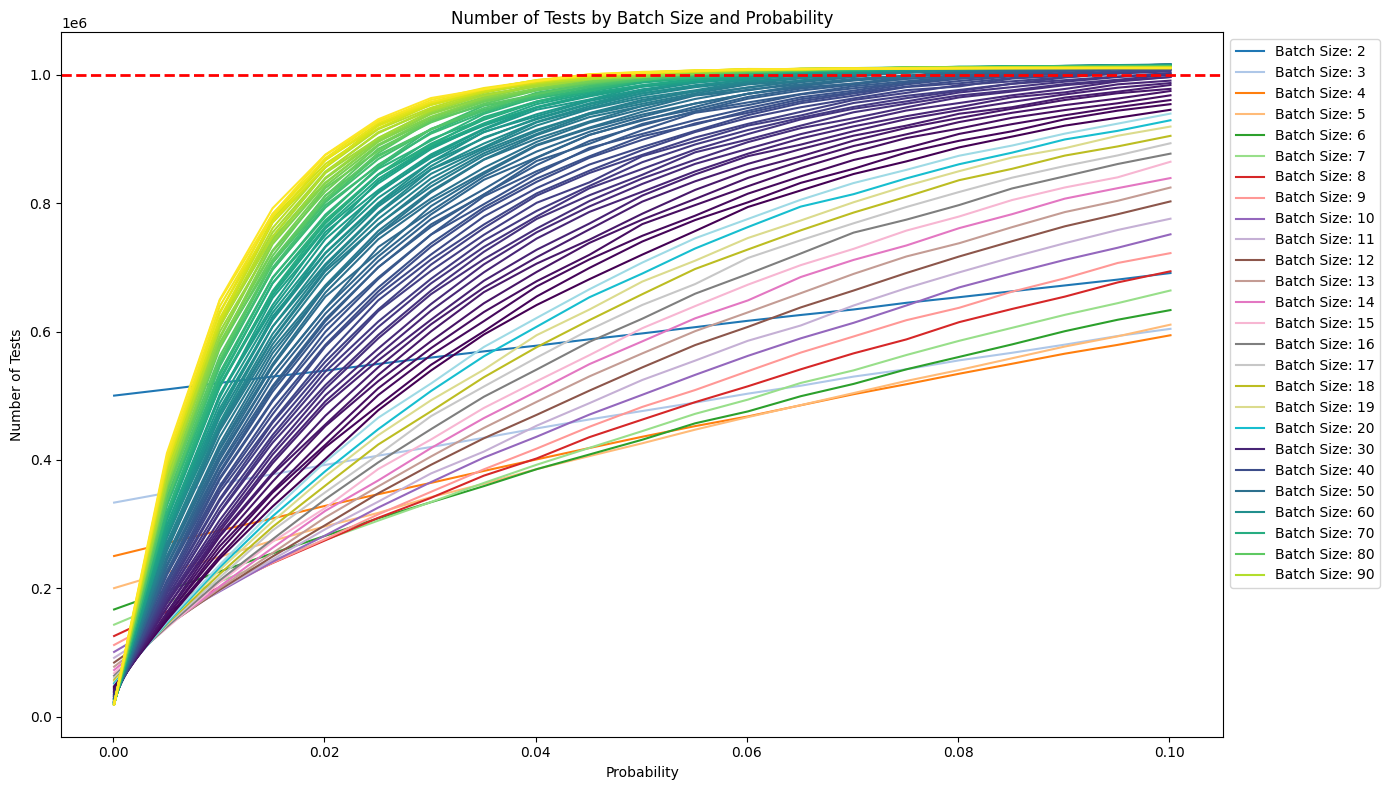

In [10]:
# Plotting
plot_MC_sim(sim_1)

In [32]:
sim_1_plotly = plot_interactive_monte_carlo(sim_1)
iplot(sim_1_plotly)

In [51]:
plot(sim_1_plotly, filename='sim_1_plot.html')

'sim_1_plot.html'

### Sim 2: P: 0.0001 - 0.0050 (0.0001), k: 15 - 100

In [16]:
# Blood Samples
N = 1000000

# Probabilities: from 0.1 to 0.0001
start = 0.0001
end =   0.0050
step =  0.0001
probabilities = np.arange(start, end + step, step)

# Probabilities: from 0.1 to 0.0001
batch_sizes = range(15,100)

# Simulation
sim_2 = simulate_monte_carlo(probabilities, batch_sizes, sample_size=N)

In [43]:
# Saving the dataframe
sim_2.to_csv('../MAS - Individual Assignment/sim_2.csv', index=True)

In [17]:
# Optimal Batch Size
sim_2_optimals = find_optimal_batch_size(sim_2)
print(sim_2_optimals)

{0.0001: 94, 0.0002: 87, 0.00030000000000000003: 75, 0.0004: 51, 0.0005: 43, 0.0006000000000000001: 47, 0.0007000000000000001: 41, 0.0008: 42, 0.0009000000000000001: 38, 0.001: 39, 0.0011: 40, 0.0012000000000000001: 33, 0.0013000000000000002: 31, 0.0014000000000000002: 27, 0.0015: 27, 0.0016: 23, 0.0017000000000000001: 22, 0.0018000000000000002: 24, 0.0019000000000000002: 25, 0.002: 24, 0.0021: 20, 0.0022: 21, 0.0023: 23, 0.0024: 21, 0.0025: 22, 0.0026: 23, 0.0027: 17, 0.0028: 18, 0.0029: 20, 0.003: 21, 0.0031: 18, 0.0032: 19, 0.0033: 18, 0.0034: 18, 0.0035: 17, 0.0036: 16, 0.0037: 17, 0.0038: 15, 0.0039: 15, 0.004: 16, 0.0041: 17, 0.004200000000000001: 15, 0.004300000000000001: 15, 0.0044: 15, 0.0045000000000000005: 15, 0.004600000000000001: 15, 0.0047: 17, 0.0048000000000000004: 15, 0.004900000000000001: 15, 0.005: 16}


In [1]:
# Plotting
plot_MC_sim(sim_2)

NameError: name 'plot_MC_sim' is not defined

In [34]:
sim_2_plotly = plot_interactive_monte_carlo(sim_2)
iplot(sim_2_plotly)

In [231]:
plot(sim_2_plotly, filename='sim_2_plot.html')

NameError: name 'sim_2_plotly' is not defined

### Sim 3: P: 0.005 - 0.10 (0.0001), k: 2 - 20

In [35]:
# Blood Samples
N = 1000000

# Probabilities: from 0.1 to 0.0001
start = 0.0100
end =   0.1000
step =  0.0001
probabilities = np.arange(start, end + step, step)

# Probabilities: from 0.1 to 0.0001
batch_sizes = range(2,20)

# Simulation
sim_3 = simulate_monte_carlo(probabilities, batch_sizes, sample_size=N)

In [41]:
# Saving the dataframe
sim_3.to_csv('../MAS - Individual Assignment/sim_3.csv', index=True)

In [39]:
# Optimal Batch Size
sim_3_optimals = find_optimal_batch_size(sim_3)
print(sim_3_optimals)

{0.01: 10, 0.0101: 10, 0.010199999999999999: 11, 0.010299999999999998: 10, 0.010399999999999998: 11, 0.010499999999999997: 11, 0.010599999999999997: 10, 0.010699999999999996: 10, 0.010799999999999995: 11, 0.010899999999999995: 11, 0.010999999999999994: 10, 0.011099999999999994: 10, 0.011199999999999993: 11, 0.011299999999999992: 10, 0.011399999999999992: 10, 0.011499999999999991: 10, 0.01159999999999999: 10, 0.01169999999999999: 9, 0.01179999999999999: 10, 0.011899999999999989: 11, 0.011999999999999988: 9, 0.012099999999999988: 10, 0.012199999999999987: 9, 0.012299999999999986: 9, 0.012399999999999986: 9, 0.012499999999999985: 9, 0.012599999999999984: 9, 0.012699999999999984: 9, 0.012799999999999983: 9, 0.012899999999999983: 9, 0.012999999999999982: 10, 0.013099999999999981: 9, 0.01319999999999998: 10, 0.01329999999999998: 10, 0.01339999999999998: 10, 0.013499999999999979: 10, 0.013599999999999978: 9, 0.013699999999999978: 9, 0.013799999999999977: 9, 0.013899999999999977: 9, 0.01399999

In [230]:
sim_3_plotly = plot_interactive_monte_carlo(sim_3)
iplot(sim_3_plotly)

NameError: name 'sim_3' is not defined

In [48]:
from plotly.offline import plot
plot(sim_3_plotly, filename='sim_3_plot.html')

'sim_3_plot.html'

In [232]:
sim_3.mean(axis=1)

NameError: name 'sim_3' is not defined

### Sim 4

In [11]:
# Blood Samples
N = 1000000

# Probabilities: from 0.1 to 0.0001
start = 0.0001
end =   0.1000
step =  0.0001
probabilities = np.arange(start, end + step, step)

# Probabilities: from 0.1 to 0.0001
batch_sizes = range(3,8)

# Simulation
sim_4 = simulate_monte_carlo(probabilities, batch_sizes, sample_size=N)

In [233]:
sim_4.mean(axis=1)

3    473728.885
4    431131.236
5     419246.63
6    421623.016
7    431225.173
dtype: object

In [242]:
sim_4_plotly = plot_interactive_monte_carlo(sim_4)
sim_4_plotly

In [243]:
plot(sim_4_plotly, filename='sim_4_plotly.html')

'sim_4_plotly.html'

### Probabilitiy of Positive

## Thompson Sampling for Multi-Armed Bandits

In [86]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.special import gamma

from itertools import permutations 
from scipy.stats import beta


### (2a) Beta distributions to model uncertainty about probabilities
Consider a bandit that for each pull of an arm, produces a binary reward: $r = 1$ (with probability $p$) or $r = 0$ (with probability $1 − p$).

Assuming the bandit has $K$ arms, this means that there are $K$ unknown probabilities $p_1, p_2, . . . , p_K$ and we need to identify the arm that has the highest probability:

$$
p_∗ = \operatorname{ max }{p_{1},p_{2},...,p_{K}},
$$

as pulling this arm will result in the highest cumulative reward.

**Using the beta-distribution to model the uncertainty on a probability**. Initially we have no information (total uncertainty) about the values of the probabilities, but each pull of an arm yields a binary outcome (reward), providing some information about the underlying probability, and thus reducing the corresponding uncertainty.

We model our uncertainty about the actual (but unknown) value $p$ using a [[beta distribution]]. This is a (unimodal) probability distribution on the interval $[0, 1]$ which depends on two parameters: $\alpha, \beta \geq 1$. The explicit distribution is given by (for $\alpha$, $\beta$ integers!):

$$
B(x;\alpha,\beta)= \frac{(\alpha+\beta−1)!}{(\alpha − 1)! (\beta − 1)!} x^{α−1}(1−x)^{\beta−1}
$$
for $0 \leq x \leq 1$.

The parameters $\alpha$ and $\beta$ determine the shape of the distribution:

**(1)** If $\alpha = \beta = 1$ then we have the uniform distribution.

**(2)** If $\alpha = \beta$ the distribution is symmetric about $x = \frac{1}{2}$.

**(3)** If $\alpha > \beta$ the density is right-leaning (i.e., concentrated in the neighbourhood of $1$). In fact, one can compute the mean explicitly:
$$
X \sim B(x;\alpha,\beta) \implies EX= \frac{\alpha}{\alpha+\beta} = \frac{1}{1+\left( \frac{\beta}{\alpha} \right)}
$$
indicating that the ratio $\frac{\beta}{\alpha}$ determines the position of the mean.

**(4)** Larger values of α and β produce a more peaked distribution. This follows from the formula for the variance:
$$
X \sim B(x;\alpha,\beta) \implies \operatorname{ Var }(X)= \frac{\alpha\beta}{(\alpha + \beta)^{2}(\alpha + \beta + 1)}
$$

In [186]:
class BETA:
    def __init__(self, alpha=1, beta=1):
        self.a = alpha
        self.b = beta
    
    # INTEGERS
    def compute_value(self, x):
        '''
        Calculating the value of the PDF of the Beta distribution at x, for the given a and b. 
        '''
        # Checks
        if not isinstance(self.a, int):
            raise ValueError("a must be an integer.")
        if not isinstance(self.b, int):
            raise ValueError("b must be an integer.")
        if not self.a >= 1:
            raise ValueError("a must be greater than or equal to 1.")
        if not self.b >= 1:
            raise ValueError("b must be greater than or equal to 1.")
        
        # Formula
        term1 = math.factorial(self.a + self.b-1)/(math.factorial(self.a - 1)*math.factorial(self.b - 1))
        term2 = x**(self.a - 1)
        term3 = (1-x)**(self.b - 1)
        f = term1*term2*term3

        # Return
        return f
    
    def distribution_int(self, num_points=100):
        # Generate x values
        x_values = np.linspace(0, 1, num_points)

        # Calculate the Beta distribution
        beta_values = [self.compute_value(x) for x in x_values]

        return beta_values
    
    def mean(self):
        return self.a / (self.a + self.b)

    def variance(self):
        return (self.a * self.b) / ((self.a + self.b)**2 * (self.a + self.b + 1))
    
    def thomson_update(self,reward):
        if reward==1:
            self.a += 1
        if reward==0:
            self.b += 1


In [170]:
def plot_beta_distributions(beta_objects, num_points=100):
    x_values = np.linspace(0, 1, num_points)
    df = pd.DataFrame({'x': x_values})

    # Prepare DataFrame with distributions
    for beta_obj in beta_objects:
        distribution = beta_obj.distribution_int(num_points)
        label = f'$\\alpha$={beta_obj.a}, $\\beta$={beta_obj.b}'
        df[label] = distribution

    # Reshape DataFrame for seaborn's lineplot
    df_melted = df.melt(id_vars='x', var_name='Parameters', value_name='Probability Density')

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_melted, x='x', y='Probability Density', hue='Parameters', palette='viridis')

    # Customizing the plot
    if len(beta_objects) > 1:
        plt.title('Beta Distributions for Different $\\alpha$ and $\\beta$ Values \n Annotated: "Mean (Variance)')
    else:
        plt.title('Beta Distribution')

    plt.xlabel('x')
    plt.ylabel('Probability Density')
    sns.despine()

    # Annotate mean and variance
    for beta_obj in beta_objects:
        mean = beta_obj.mean()
        variance = beta_obj.variance()
        plt.annotate(
            f'{mean:.2f} ({variance:.3f})', 
            xy=(mean, beta_obj.compute_value(mean)), 
            xytext=(mean, beta_obj.compute_value(mean)+ 0.05),  # Adjust vertical offset
            fontsize=9, ha='center', va='bottom', font="Times"
        )

    plt.legend(title='Parameters')
    plt.show()

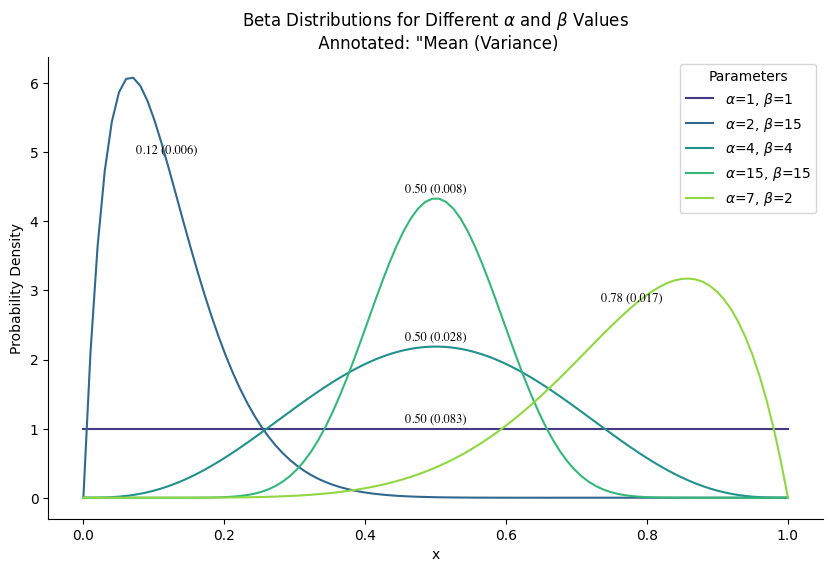

In [181]:
b1 = BETA()
b2 = BETA(2, 15)
b3 = BETA(4, 4)
b4 = BETA(15, 15)
b5 = BETA(7, 2)

plot_beta_distributions([b1, b2, b3, b4, b5])


### (2b) Thompson’s Bayesian update rule
Although the beta-distribution seems like a reasonable model to quantify the uncertainty on a probability, there is a deeper reason for its use. 

Updating a (prior) beta-density with binary observations, results in a new beta-density with updated parameters (this is an example of what is known as **conjugated priors**). Specifically, if the prior is modeled as $B(x, \alpha, \beta)$, and we observe $s$ successes (1) and $f$ failures (0) then the posterior would be the beta distribution $B(x; \alpha+s, \beta+f)$. This observation yields the rationale for Thompson’s Bayesian update rule:
1. Sample from the bandit and get reward $r$ (either $r = 1$ or $r = 0$).
2. Update the values for $\alpha$ and $\beta$ as follows:
	- if $r=1$, then $\alpha \leftarrow \alpha+1$
	- if $r=0$, then $\beta \leftarrow \beta+1$
- This update rule can be summarised as:
$$
\alpha \leftarrow \alpha+1 \quad \beta \leftarrow \beta+(1-r)
$$

**Task**: Implement the Thompson update rule for single arm bandit (i.e., $k = 1$) and show experimentally that the Beta-density increasingly peaks at the correct value for $p$. To this end, plot both the evolution of the mean and variance over (iteration)time.

In [214]:
def thompson_for_bandit(probability, # that it is true
                        n_iterations=100):
    means = []
    variances = []

    # Initializing with a = 1, b = 1.
    BETA_dist = BETA()

    for i in range(n_iterations):
        # Simulate pulling the arm
        reward = np.random.binomial(1, probability)

        # Update alpha and beta in the BETA object
        BETA_dist.thomson_update(reward)

        # Calculating the new mean and variance
        mean = BETA_dist.mean()
        variance = BETA_dist.variance()

        means.append(mean)
        variances.append(variance)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plotting the evolution of mean
    plt.subplot(1, 2, 1)
    plt.plot(means, label='Mean', color="green")
    plt.axhline(y=probability, color='black', linestyle='--', label='Underlying\nProbability')
    plt.title('Evolution of Mean')
    plt.xlabel('Iterations')
    plt.ylabel('Mean')
    plt.legend()

    # Plotting the evolution of variance
    plt.subplot(1, 2, 2)
    plt.plot(variances, label='Variance', color="purple")
    plt.title('Evolution of Variance')
    plt.xlabel('Iterations')
    plt.ylabel('Variance')
    plt.legend()

    plt.tight_layout()
    plt.show()


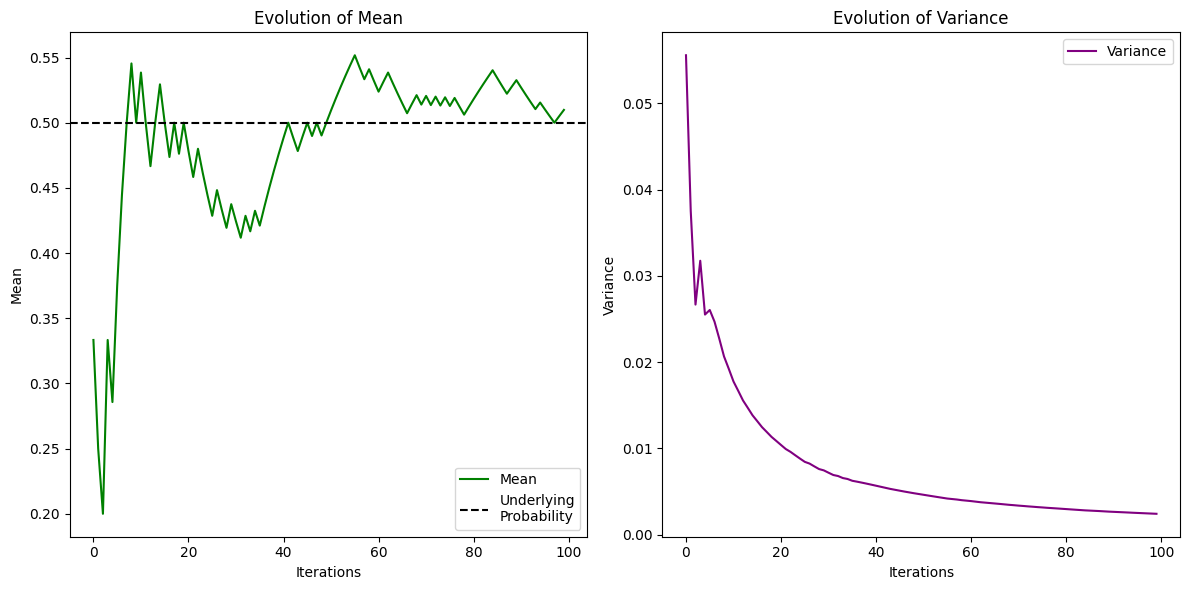

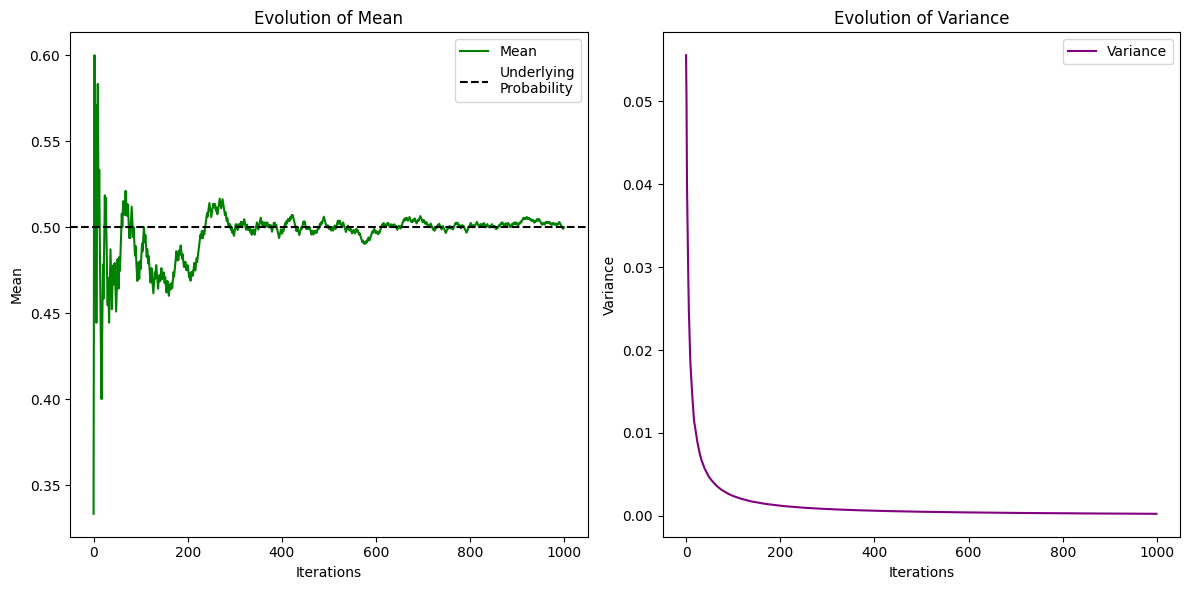

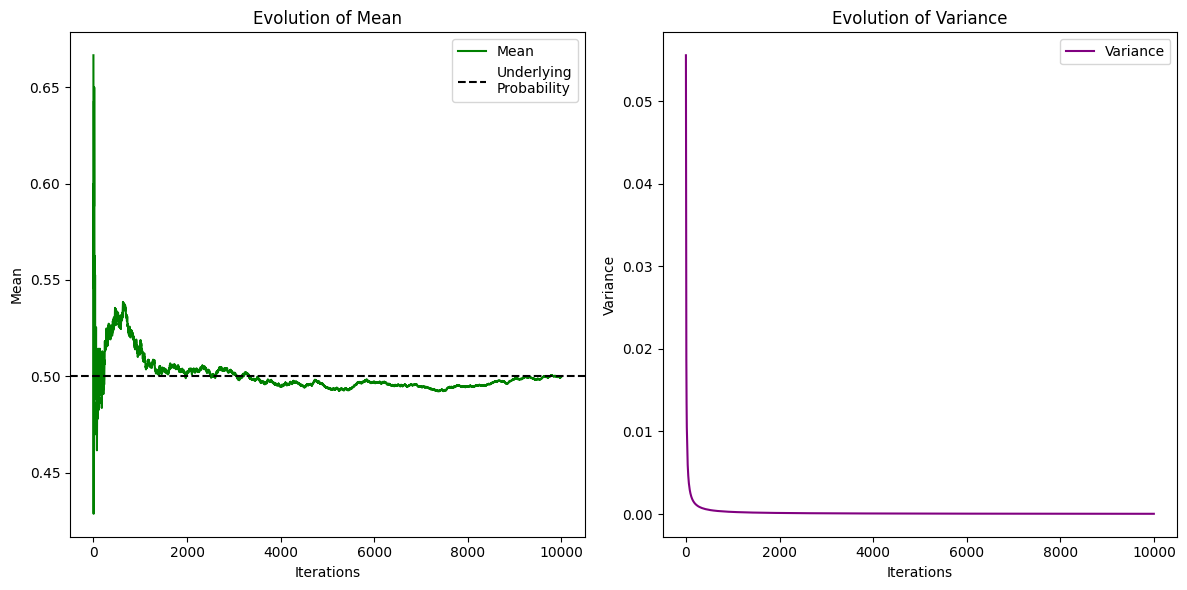

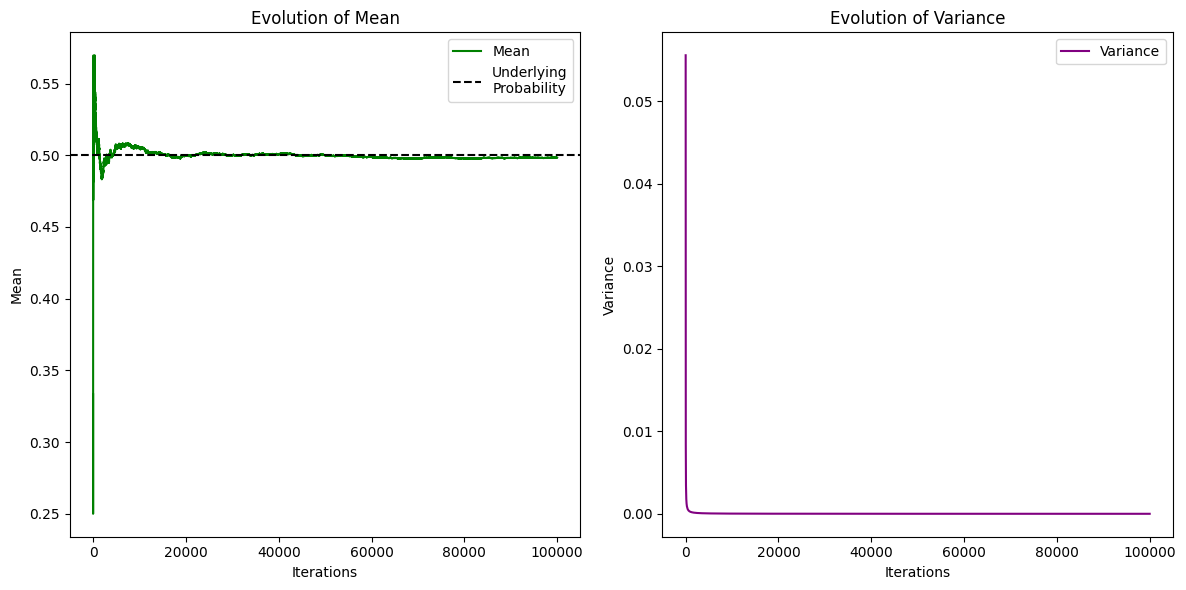

In [215]:
thompson_for_bandit(0.5, 100)
thompson_for_bandit(0.5, 1000)
thompson_for_bandit(0.5, 10000)
thompson_for_bandit(0.5, 100000)



### (2c) Thompson sampling for K-armed bandit Problem
For binary outcomes, the Thompson update rule offers an alternative for the UCB-based balancing of exploration and exploitation. Specifically, suppose we have a K-armed bandit problem. The $k$-th arm delivers a reward $r = 1$ with (unknown!) probability $p_{k}$ (and hence $r = 0$ with probability $1 − p_{k}$). For each arm $(k = 1, . . . , K)$, the uncertainty about the corresponding $p_{k}$ is modelled using a Beta-distribution $B(x;\alpha_{k},\beta_{k})$. Thompson sampling now tries to identify the arm that will deliver the maximal cumulative reward (highest $p_{k}$) by proceeding as follows. Initialise all parameters to 1: $\alpha_{k} = 1 = \beta_{k}$; Now repeat the following loop:

**(1)** We use the beta-distributions to simulate the pulling of each arm. This means that we sample a value $U_{k}$ from each of the $K$ Beta-distributions:  
$$
U_{k} \sim B(x;\alpha_{k},\beta_{k}) \quad (k = 1 \dots K)
$$

**(2)** For this simulation, determine which arm gave the best result: 
$$
k_{\operatorname{ max }} \operatorname{ arg max } \{ U_{1},U_{2},\dots,U_{K} \}
$$

**(3)** Mindful of the uncertainties on the $p_{k}$-values, the above simulation gives us reason to believe that pulling the $k_{\operatorname{ max }}$ arm is rational (after all, we did a simulation using the available evidence, and this was the result).

**(4)** Sample the corresponding arm (i.e. arm $k_{\operatorname{ max }}$) and get reward $r$ (either $1$ or $0$);

**(5)** Use the Bayesian update rule for the corresponding parameters:
$$
\begin{align}
\alpha k_{\operatorname{ max }} &\leftarrow \alpha k_{\operatorname{ max }} \\
\beta k_{\operatorname{ max }} &\leftarrow \beta + (1-r) k_{\operatorname{ max }}
\end{align}
$$

**Task**: Write code to implement Thompson sampling for the above scenario when $K = 3$.

**Task**: Perform numerical experiments in which you compare Thompson sampling with the UCB. Use total regret (provide the precise definition that you’re using) as your performance criteria. For UCB, experiment with different values of the hyperparameter $c$. The fact that, for Thompson sampling, you don’t need to specify an hyperparameter, is a distinct advantage.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of arms
K = 3

# True probabilities for each arm
p_true = [0.3, 0.5, 0.7]  # Example probabilities for each of the 3 arms

# Initialize alpha and beta for each arm
alpha = np.ones(K)
beta = np.ones(K)

# Number of iterations
n_iterations = 1000

# Function for Thompson Sampling for K-armed bandit
def thompson_sampling(K, alpha, beta, p_true, n_iterations):
    rewards = np.zeros(K)
    selections = np.zeros(K)
    total_reward = 0

    for _ in range(n_iterations):
        # Step 1: Sample from beta distributions
        theta = [np.random.beta(alpha[k], beta[k]) for k in range(K)]
        
        # Step 2: Choose the arm with the highest sample
        k_max = np.argmax(theta)

        # Step 4: Pull the chosen arm and get reward
        reward = np.random.binomial(1, p_true[k_max])

        # Step 5: Update alpha and beta for chosen arm
        alpha[k_max] += reward
        beta[k_max] += 1 - reward

        # Update rewards and selections
        rewards[k_max] += reward
        selections[k_max] += 1
        total_reward += reward

    return rewards, selections, total_reward

# Perform Thompson Sampling
rewards, selections, total_reward = thompson_sampling(K, alpha, beta, p_true, n_iterations)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot for selections of each arm
plt.subplot(1, 2, 1)
plt.bar(range(K), selections, color='blue')
plt.title('Number of times each arm was selected')
plt.xlabel('Arms')
plt.ylabel('Number of selections')

# Plot for rewards of each arm
plt.subplot(1, 2, 2)
plt.bar(range(K), rewards, color='green')
plt.title('Total rewards from each arm')
plt.xlabel('Arms')
plt.ylabel('Total Reward')

plt.tight_layout()
plt.show()

# Total reward
total_reward